Trying out with Python

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
data = pd.read_csv('./Data/table.csv')
d = data.copy()
# data.head()

In [17]:
l = []
for i in range(0, len(d)):
    # d["venue"][i] = list(' '.split(d["venue"][i]))[-2]
    l.append(str(d["venue"][i].split()[-1]))

# print(l)
d["location"] = l
# d.head()


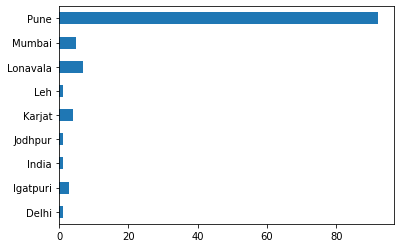

In [20]:
d.location.value_counts(dropna=False).sort_index().plot(kind='barh')
# plt.show()
d['location'] = d['location'].str.lower()

In [ ]:
import numpy as np
import pandas as pd
from flask import Flask, render_template, request
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
import bs4 as bs
import urllib.request
import pickle
import requests

# load the nlp model and tfidf vectorizer from disk
filename = 'nlp_model.pkl'
clf = pickle.load(open(filename, 'rb'))
vectorizer = pickle.load(open('tranform.pkl','rb'))

def create_similarity():
    data = pd.read_csv('main_data.csv')
    # creating a count matrix
    cv = CountVectorizer()
    count_matrix = cv.fit_transform(data['comb'])
    # creating a similarity score matrix
    similarity = cosine_similarity(count_matrix)
    return data,similarity

def rcmd(m):
    m = m.lower()
    try:
        data.head()
        similarity.shape
    except:
        data, similarity = create_similarity()
    if m not in data['movie_title'].unique():
        return('Sorry! The movie you requested is not in our database. Please check the spelling or try with some other movies')
    else:
        i = data.loc[data['movie_title']==m].index[0]
        lst = list(enumerate(similarity[i]))
        lst = sorted(lst, key = lambda x:x[1] ,reverse=True)
        lst = lst[1:11] # excluding first item since it is the requested movie itself
        l = []
        for i in range(len(lst)):
            a = lst[i][0]
            l.append(data['movie_title'][a])
        return l
    
# converting list of string to list (eg. "["abc","def"]" to ["abc","def"])
def convert_to_list(my_list):
    my_list = my_list.split('","')
    my_list[0] = my_list[0].replace('["','')
    my_list[-1] = my_list[-1].replace('"]','')
    return my_list

def get_suggestions():
    data = pd.read_csv('main_data.csv')
    return list(data['movie_title'].str.capitalize())

app = Flask(__name__)

@app.route("/")
@app.route("/home")
def home():
    suggestions = get_suggestions()
    return render_template('home.html',suggestions=suggestions)

@app.route("/similarity",methods=["POST"])
def similarity():
    movie = request.form['name']
    rc = rcmd(movie)
    if type(rc)==type('string'):
        return rc
    else:
        m_str="---".join(rc)
        return m_str

@app.route("/recommend",methods=["POST"])
def recommend():
    # getting data from AJAX request
    title = request.form['title']
    cast_ids = request.form['cast_ids']
    cast_names = request.form['cast_names']
    cast_chars = request.form['cast_chars']
    cast_bdays = request.form['cast_bdays']
    cast_bios = request.form['cast_bios']
    cast_places = request.form['cast_places']
    cast_profiles = request.form['cast_profiles']
    imdb_id = request.form['imdb_id']
    poster = request.form['poster']
    genres = request.form['genres']
    overview = request.form['overview']
    vote_average = request.form['rating']
    vote_count = request.form['vote_count']
    release_date = request.form['release_date']
    runtime = request.form['runtime']
    status = request.form['status']
    rec_movies = request.form['rec_movies']
    rec_posters = request.form['rec_posters']

    # get movie suggestions for auto complete
    suggestions = get_suggestions()

    # call the convert_to_list function for every string that needs to be converted to list
    rec_movies = convert_to_list(rec_movies)
    rec_posters = convert_to_list(rec_posters)
    cast_names = convert_to_list(cast_names)
    cast_chars = convert_to_list(cast_chars)
    cast_profiles = convert_to_list(cast_profiles)
    cast_bdays = convert_to_list(cast_bdays)
    cast_bios = convert_to_list(cast_bios)
    cast_places = convert_to_list(cast_places)
    
    # convert string to list (eg. "[1,2,3]" to [1,2,3])
    cast_ids = cast_ids.split(',')
    cast_ids[0] = cast_ids[0].replace("[","")
    cast_ids[-1] = cast_ids[-1].replace("]","")
    
    # rendering the string to python string
    for i in range(len(cast_bios)):
        cast_bios[i] = cast_bios[i].replace(r'\n', '\n').replace(r'\"','\"')
    
    # combining multiple lists as a dictionary which can be passed to the html file so that it can be processed easily and the order of information will be preserved
    movie_cards = {rec_posters[i]: rec_movies[i] for i in range(len(rec_posters))}
    
    casts = {cast_names[i]:[cast_ids[i], cast_chars[i], cast_profiles[i]] for i in range(len(cast_profiles))}

    cast_details = {cast_names[i]:[cast_ids[i], cast_profiles[i], cast_bdays[i], cast_places[i], cast_bios[i]] for i in range(len(cast_places))}

    # web scraping to get user reviews from IMDB site
    sauce = urllib.request.urlopen('https://www.imdb.com/title/{}/reviews?ref_=tt_ov_rt'.format(imdb_id)).read()
    soup = bs.BeautifulSoup(sauce,'lxml')
    soup_result = soup.find_all("div",{"class":"text show-more__control"})

    reviews_list = [] # list of reviews
    reviews_status = [] # list of comments (good or bad)
    for reviews in soup_result:
        if reviews.string:
            reviews_list.append(reviews.string)
            # passing the review to our model
            movie_review_list = np.array([reviews.string])
            movie_vector = vectorizer.transform(movie_review_list)
            pred = clf.predict(movie_vector)
            reviews_status.append('Good' if pred else 'Bad')

    # combining reviews and comments into a dictionary
    movie_reviews = {reviews_list[i]: reviews_status[i] for i in range(len(reviews_list))}     

    # passing all the data to the html file
    return render_template('recommend.html',title=title,poster=poster,overview=overview,vote_average=vote_average,
        vote_count=vote_count,release_date=release_date,runtime=runtime,status=status,genres=genres,
        movie_cards=movie_cards,reviews=movie_reviews,casts=casts,cast_details=cast_details)

if __name__ == '__main__':
    app.run(debug=True)